<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [2]:
!pip install datasets

Импорт необходимых библиотек

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [12]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences

vocab_size = 40000    # размер словаря


sentences = []
for sample in tqdm(dataset['train']['text']):   # в imdb нет 'validation', поэтому берём train
    for s in sent_tokenize(sample):
        words = word_tokenize(s.lower())   # токенизация по словам
        if len(words) <= word_threshold:   # фильтр по длине
            sentences.append(" ".join(words))

print("Всего предложений:", len(sentences))

  0%|          | 0/25000 [00:00<?, ?it/s]

Всего предложений: 202657


Посчитаем для каждого слова его встречаемость.

In [14]:
words = Counter()

# Расчет встречаемости слов


word_counts = Counter()
for s in tqdm(sentences):
    word_counts.update(word_tokenize(s))

special_tokens = ['<unk>', '<bos>', '<eos>', '<pad>']
most_common_words = [w for w, _ in word_counts.most_common(vocab_size)]
vocab = set(special_tokens + most_common_words)

word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}


  0%|          | 0/202657 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [15]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [16]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [17]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [21]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # токенизируем предложение
        words = word_tokenize(self.data[idx])

        # BOS + индексы слов + EOS
        tokenized_sentence = [self.bos_id] + \
                             [word2ind.get(w, self.unk_id) for w in words] + \
                             [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)


In [19]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [22]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size, shuffle=True)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)


'''

train_dataloader = DataLoader(
    train_dataset, collate_fn=lambda b: collate_fn_with_padding(b, word2ind['<pad>']),
    batch_size=batch_size, shuffle=True
)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=lambda b: collate_fn_with_padding(b, word2ind['<pad>']),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset, collate_fn=lambda b: collate_fn_with_padding(b, word2ind['<pad>']),
    batch_size=batch_size
)
'''


"\n\ntrain_dataloader = DataLoader(\n    train_dataset, collate_fn=lambda b: collate_fn_with_padding(b, word2ind['<pad>']),\n    batch_size=batch_size, shuffle=True\n)\n\neval_dataloader = DataLoader(\n    eval_dataset, collate_fn=lambda b: collate_fn_with_padding(b, word2ind['<pad>']),\n    batch_size=batch_size\n)\n\ntest_dataloader = DataLoader(\n    test_dataset, collate_fn=lambda b: collate_fn_with_padding(b, word2ind['<pad>']),\n    batch_size=batch_size\n)\n"

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [23]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexities = []

    with torch.no_grad():
        for batch in dataloader:
            # forward pass
            logits = model(batch['input_ids'])  # [batch, seq_len, vocab_size]

            # приводим к 2D [batch*seq_len, vocab_size]
            logits = logits.flatten(start_dim=0, end_dim=1)

            # таргеты в 1D [batch*seq_len]
            targets = batch['target_ids'].flatten()

            # считаем loss
            loss = criterion(logits, targets)

            # добавляем perplexity = exp(loss)
            perplexities.append(torch.exp(loss).item())

    return sum(perplexities) / len(perplexities)


### Train loop (1 балл)

Напишите функцию для обучения модели.

In [24]:
def train_model(model, train_dataloader, eval_dataloader, optimizer, criterion, num_epochs=10):
    train_losses = []
    eval_perplexities = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            # forward
            logits = model(batch['input_ids'])   # [batch, seq_len, vocab_size]
            logits = logits.flatten(start_dim=0, end_dim=1)  # [batch*seq_len, vocab_size]
            targets = batch['target_ids'].flatten()          # [batch*seq_len]

            # loss
            loss = criterion(logits, targets)

            # backward
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        # средний loss за эпоху
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_loss)

        # считаем perplexity на валидации
        ppl = evaluate(model, criterion, eval_dataloader)
        eval_perplexities.append(ppl)

        print(f"Epoch {epoch+1}: train_loss = {avg_loss:.4f}, val_ppl = {ppl:.2f}")

    return train_losses, eval_perplexities


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [25]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.2):
        super().__init__()

        # Встраивание слов (эмбеддинг)
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=word2ind['<pad>'])

        # LSTM
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Проекция в пространство словаря
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # input_batch: [batch, seq_len]
        embeddings = self.embedding(input_batch)             # [batch, seq_len, emb_dim]
        output, _ = self.lstm(embeddings)                    # [batch, seq_len, hidden_dim]
        logits = self.linear(output)                         # [batch, seq_len, vocab_size]
        return logits


In [27]:
# Обучение

model = LanguageModel(vocab_size=len(vocab)).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


train_losses, eval_perplexities = train_model(
    model, train_dataloader, eval_dataloader,
    optimizer, criterion, num_epochs=10
)


Epoch 1/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 1: train_loss = 5.4689, val_ppl = 146.27


Epoch 2/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 2: train_loss = 4.8655, val_ppl = 110.33


Epoch 3/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 3: train_loss = 4.6305, val_ppl = 91.96


Epoch 4/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 4: train_loss = 4.4633, val_ppl = 80.64


Epoch 5/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 5: train_loss = 4.3329, val_ppl = 72.85


Epoch 6/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 6: train_loss = 4.2247, val_ppl = 67.28


Epoch 7/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 7: train_loss = 4.1324, val_ppl = 62.62


Epoch 8/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 8: train_loss = 4.0513, val_ppl = 59.15


Epoch 9/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 9: train_loss = 3.9794, val_ppl = 56.24


Epoch 10/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 10: train_loss = 3.9146, val_ppl = 53.78


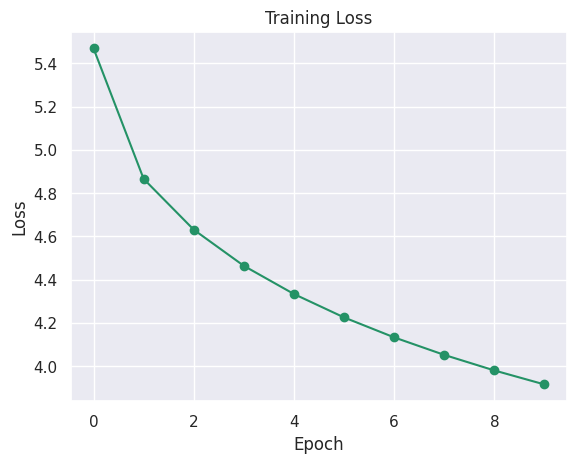

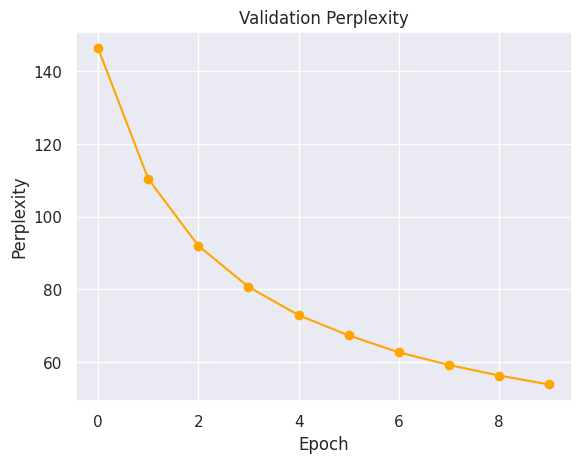

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# График функции потерь
plt.plot(np.arange(len(train_losses)), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# График перплексии
plt.plot(np.arange(len(eval_perplexities)), eval_perplexities, marker='o', color='orange')
plt.title('Validation Perplexity')
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [31]:
class LanguageModel2(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()

        # Эмбеддинги слов
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=word2ind['<pad>'])

        # Двухслойная LSTM
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Линейная проекция
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)     # [batch, seq_len, emb_dim]
        output, _ = self.lstm(embeddings)            # [batch, seq_len, hidden_dim]
        logits = self.linear(output)                 # [batch, seq_len, vocab_size]
        return logits


In [33]:
# создаём модель
model2 = LanguageModel2(vocab_size=len(vocab)).to(device)

# функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

# обучение
train_losses2, eval_perplexities2 = train_model(
    model2, train_dataloader, eval_dataloader,
    optimizer, criterion, num_epochs=10
)


Epoch 1/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 1: train_loss = 6.0058, val_ppl = 206.05


Epoch 2/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 2: train_loss = 5.1363, val_ppl = 137.56


Epoch 3/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 3: train_loss = 4.8699, val_ppl = 113.24


Epoch 4/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 4: train_loss = 4.7080, val_ppl = 98.68


Epoch 5/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 5: train_loss = 4.5866, val_ppl = 88.92


Epoch 6/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 6: train_loss = 4.4887, val_ppl = 81.69


Epoch 7/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 7: train_loss = 4.4053, val_ppl = 75.89


Epoch 8/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 8: train_loss = 4.3332, val_ppl = 71.49


Epoch 9/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 9: train_loss = 4.2698, val_ppl = 67.82


Epoch 10/10:   0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 10: train_loss = 4.2139, val_ppl = 64.81


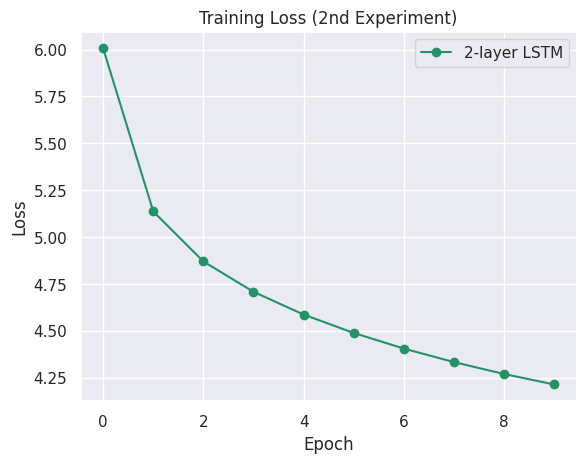

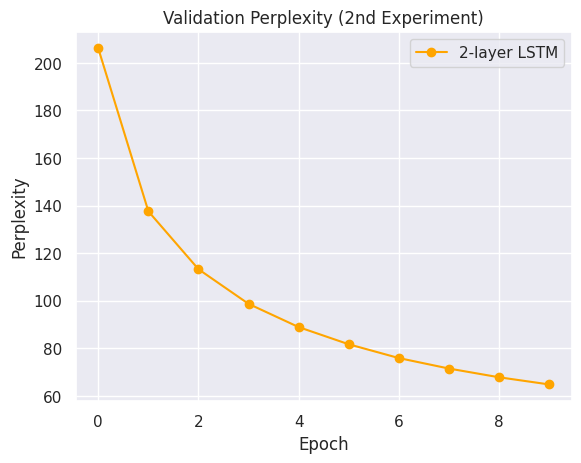

In [34]:
# Training loss
plt.plot(np.arange(len(train_losses2)), train_losses2, marker='o', label="2-layer LSTM")
plt.title('Training Loss (2nd Experiment)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Validation perplexity
plt.plot(np.arange(len(eval_perplexities2)), eval_perplexities2, marker='o', color='orange', label="2-layer LSTM")
plt.title('Validation Perplexity (2nd Experiment)')
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.legend()
plt.show()


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.



В первом эксперименте я обучила простую однослойную LSTM-модель. Она довольно быстро начала сходиться: уже к 10-й эпохе значение функции потерь снизилось до ~3.9, а перплексия упала до ~54. Это значит, что модель смогла выучить статистику слов и стала предсказывать следующий токен значительно лучше, чем на старте.

Во втором эксперименте я усложнила архитектуру и сделала двухслойную LSTM. На старте получилось хуже — лосс был выше (около 6.0), а перплексия больше 200. К концу десятой эпохи значения улучшились (loss ≈ 4.2, perplexity ≈ 65), но всё равно результат оказался хуже, чем у однослойной модели. Более глубокая сеть требует больше времени на обучение или других гиперпараметров, а при тех же настройках она может недообучаться.

Если сравнивать, то однослойная LSTM в этих условиях оказалась эффективнее: она и обучалась быстрее, и выдала меньшую перплексию. Двухслойная, скорее всего, раскроет себя, если увеличить число эпох, подобрать другую скорость обучения или уменьшить dropout.

Что можно попробовать дальше:
- обучить модели дольше (20–30 эпох),
- поэкспериментировать с размером скрытого состояния (например, hidden=512),
- поиграться с dropout (может быть, 0.1 будет лучше, чем 0.3),
- попробовать GRU, как мы делали на семинаре — иногда она работает лучше на том же объёме данных,
- или перейти на сабворд-токенизацию (BPE), чтобы словарь был меньше и модель училась устойчивее.